# Task 4 - Neural Networks
The objective of this task was to build different classifiers using base feedforward neural networks, varying the different configurations that can be applied to them.


## Objetivo

El objetivo de esta tarea es construir diferentes clasificadores utilizando redes neuronales *feedforward* base, variando las distintas configuraciones que se pueden hacer a las mismas. Esto con el fin de que los clasificadores devuelvan, para una imagen de entrada, una distribución de probabilidad sobre las categorías que puede tomar una imagen, asignandole posteriormente la categoría más probable.

El éxito del aprendizaje se mide a través de el análisis de la performance sobre el conjunto de evaluación, en un principio basándose principalmente en la métrica *accuracy*, y luego también en otras subpartes mediante la construcción de la matriz de confusión, utilizando *accuracy*, *precisión*, *recall* y medida F1 para cada una de las clases.


## Parte A

### i) Defina un red neuronal *feedforward* base con una capa oculta de 32 unidades y que utilice la función sigmoide como activación, que devuelva, para una imagen de entrada, una distribución de probabilidad sobre las categorías, y permita asignarle la categoría más probable.

Primero realizamos los imports necesarios, basándonos en la librería *PyTorch* como indica la letra. Utilizamos "*torchvision*" ya que esta ofrece una forma integrada de descargar y usar Fashion-MNIST, el cual es un conjunto de datos con imágenes de 10 tipos diferentes de artículos de la empresa de vestimenta Zalando, con 60.000 instancias de entrenamiento y 10.000 de evaluación. Este dataset es el que utilizaremos tanto para entrenar como evaluar en sus respectivos conjuntos.

In [4]:
!pip install torch
!pip install torchvision

DEPRECATION: google-images-search 1.4.6 has a non-standard dependency specifier click>=7.0<=8.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of google-images-search or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ------------------ --------------------- 0.6/1.2 MB 17.5 MB/s eta 0:00:01
   ---------------------------------------  1.2/1.2 MB 18.5 MB/s eta 0:00:01
   ---------------------------------------  1.2/1.2 MB 18.5 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 7.4 MB/s eta 0:00:00


DEPRECATION: google-images-search 1.4.6 has a non-standard dependency specifier click>=7.0<=8.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of google-images-search or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import Subset, DataLoader

In [26]:
def set_seed(seed_value=2023):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2023)

Los métodos de "Dataset" y "DataLoader" nos permiten construir los datasets, a partir de nuestros datos, utilizando PyTorch.

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

indices = list(range(len(full_dataset)))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]


train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [33]:
print("Cantidad de elementos en el DataLoader de entrenamiento:", len(train_loader.dataset))
print("Cantidad de elementos en el DataLoader de validación:", len(val_loader.dataset))
print("Cantidad de elementos en el DataLoader de prueba:", len(test_loader.dataset))


Cantidad de elementos en el DataLoader de entrenamiento: 48000
Cantidad de elementos en el DataLoader de validación: 6000
Cantidad de elementos en el DataLoader de prueba: 6000


A continuación, construimos una red neuronal feedforward base. Para ello, definimos una clase llamada NeuralNetwork que hereda de la clase *nn.Module* de *PyTorch*, permitiendo que nuestra clase NeuralNetwork tenga acceso a métodos y atributos útiles para la construcción y entrenamiento de redes neuronales que la misma provee.

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()   # Llamamos al constructor de la clase base nn.Module
        self.fc1 = nn.Linear(28*28, 32)         # Primer capa totalmente conectada. Toma una imagen aplanada
                                                # de tamaño 28x28 como entrada y produce 32 activaciones.

        self.fc2 = nn.Linear(32, 10)            # Segunda capa que toma las 32 activaciones de la primera
                                                # y produce 10 salidas que corresponden a las 10 clases del conjunto de datos Fashion-MNIST.

        self.sigmoid = nn.Sigmoid()             # Funcion de activacion sigmoide que se aplica a las salidas de la primera capa.

    def forward(self, x):
        x = x.view(-1, 28*28)                   # Aplanamos la imagen para que pueda ser procesada por la primera capa totalmente conectada.
        x = self.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

### ii) Utilizando el conjunto de entrenamiento provisto, entrene a la red construida en el paso anterior durante 10 épocas.

### iii) Evalúe el rendimiento del clasificador construido sobre un conjunto de validación, utilizando descenso por gradiente estocástico y una tasa de aprendizaje de 0.01.


En esta sección, declaramos una función que nos permite encapsular la propuesta de entrenar un modelo durante 10 épocas con ciertas tasas de aprendizaje que deben ser indicadas. También abarca la evaluación parcial del modelo que se obtiene luego de cada época indicando la pérdida y precisión en cada una de estas. Dichas pérdidas y precisiones parciales son almacenadas y la función $evaluar \ modelo(...)$ retorna en dos listas de tamaño 10, los correspondientes valores para las 10 épocas y la última tasa de aprendizaje presente en la lista de tasas. A su vez, retornamos el modelo correspondiente a la tasa 0.1, pues dicho modelo nos resultará útil en partes posteriores del trabajo.

Por lo tanto, reunimos ambas partes en el mismo código de modo que para la parte iv) ya tengamos los datos necesarios recolectados. Es decir, a medida que entrenamos en las 10 épocas, evaluamos el comportamiento de la red en dicha época respecto al conjunto de validación. Luego, en la parte iv) podremos reportar como varían la pérdida y la precisión que presenta la red al ir aumentando el número de épocas.


Además, se decide utilizar la función de pérdida $nn.CrossEntropyLoss()$. La misma es comúnmente utilizada en tareas de clasificación de múltiples clases como este, ya que combina dos pasos en uno:

- **Log Softmax:** Aplica la función softmax a las salidas del modelo para convertirlas en probabilidades y luego toma el logaritmo de estas probabilidades.

- **Negative Log Likelihood Loss (NLLLoss):** Es una función de pérdida para clasificación que compara las probabilidades logarítmicas con el verdadero valor de clase y calcula una puntuación que indica cuán bien coinciden las salidas predichas con el valor verdadero.

De esta forma, para la red definida en i), la capa de salida, después de la sigmoide, producirá salidas "crudas" que luego serán convertidas en probabilidades por la función Softmax interna en nn.CrossEntropyLoss.

Por último, para utilizar la siguiente función también en la parte D, incluimos parámetros para indicar probabilidad de $dropout$ o $weight\_decay$ al analizar posteriormente distintas técnicas de regularización. A su vez, una flag para saber con cual técnica estaremos aplicando en la parte D.

In [34]:
def evaluar_modelo(ModeloClase, tasas, dropout = 0,l2=False,weight_decay=0,numero_epocas=10):
  precisiones = []
  perdidas = []
  modeloRet = None                                              # Para reutilizar el modelo ya entrenado posteriormente (Parte D)
  for tasa in tasas:
    output_text = f"{tasa}"
    model = None
    if dropout == 0:
                                                                      # Para cada tasa de aprendizaje, obtenemos un modelo nuevo a entrenar en 10 epocas.
                                                                      # Definimos la posibilidad de instanciar el modelo con valores para la parte c
      if l2:
        print(f"Evaluando el modelo para tasa de aprendizaje {tasa} y weight decay {weight_decay}")
        model = ModeloClase(weight_decay=weight_decay)
      else:
        print(f"Evaluando el modelo para tasa de aprendizaje: {tasa}")
        model = ModeloClase()
    else:                                                             # en donde trabajaremos con distintos métodos de regularización.

      if l2:
        print(f"Evaluando el modelo para tasa de aprendizaje {tasa} para el valor de dropout {dropout} y weight decay {weight_decay}")
        model = ModeloClase(dropout=dropout,weight_decay=weight_decay)
      else:
        print(f"Evaluando el modelo para tasa de aprendizaje {tasa} para el valor de dropout {dropout}")
        model = ModeloClase(dropout=dropout)


    criterio = nn.CrossEntropyLoss()                            # Usamos como función de pérdida: entropía cruzada, ya que es util para tareas de clasificación multiclase.
    optimizador = optim.SGD(model.parameters(), lr=tasa)        # Utilizamos descenso por gradiente estocastico,
                                                                # variando las tasas de aprendizaje.
    perdidas_en_train = []
    test_accuracies = []
    val_accuracies = []
    perdidas_en_test = []
    perdidas_en_val = []
    for epoca in range(numero_epocas):
        perdida_en_epoca = 0.0
        for data, target in train_loader:
            optimizador.zero_grad()
            outputs = model(data)
            loss = 0
            if l2:
              loss = criterio(outputs, target) + model.l2_regularization()      # Implementa la regularizacion L2
            else:
              loss = criterio(outputs, target)
            loss.backward()
            optimizador.step()
            perdida_en_epoca += loss.item()

        perdidas_en_train.append(perdida_en_epoca / len(train_loader))    # Calculamos la pérdida promedio de la época y la guardamos
        perdidas = perdidas_en_train                                # Almacenamos perdidas de la ultima epoca y ultima tasa considerada.

        # Evaluamos la precisión en el conjunto de validación, utilizando descenso por gradiente estocastico y tasa=tasa.
        correctas = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correctas += (predicted == target).sum().item()
        accuracy = 100 * correctas / total
        val_accuracies.append(accuracy)
        precisiones = val_accuracies                           # Almacenamos precisiones de la ultima epoca y ultima tasa considerada.

        # Calculamos la pérdida en el conjunto de pruebas
        perdida_test = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                outputs = model(data)
                loss = 0
                if l2:
                  loss = criterio(outputs, target) + model.l2_regularization()      # Implementa la regularizacion L2
                else:
                  loss = criterio(outputs, target)
                perdida_test += loss.item()

        perdidas_en_test.append(perdida_test / len(test_loader))

        print(f"Epoca {epoca+1}, Loss: {perdidas_en_train[-1]:.3f}, Accuracy: {accuracy}%")

    if tasa == 0.1:                                             # Retornamos el modelo entrenado para utilizarlo sin necesidad de volver a entrenar
      modeloRet = model
  return precisiones, perdidas, modeloRet, perdidas_en_test

Decidimos utilizar un batch de 32 al aplicar SGD, ya que nos pareció un buen compromiso entre la velocidad de entrenamiento y el uso eficiente de los recursos. Comparando con un batch más pequeño como 1, tiene una velocidad de convergencia mayor y un gradiente más estable, pero sin imponer una carga significativa en los recursos.

In [23]:
import matplotlib.pyplot as plt

def graficar_perdidas(perdidas_train,perdidas_test):


  # Crear gráfica
  plt.plot(perdidas_train, label='perdidas_train')
  plt.plot(perdidas_test, label='perdidas_test')

  # Agregar título y etiquetas
  plt.title('Gráfica perdidas_train y perdidas_test en funcion del tiempo')
  plt.xlabel('época')
  plt.ylabel('valor de perdida')

  # Mostrar leyenda
  plt.legend()

  # Mostrar gráfica
  plt.show()

In [35]:
precisiones_test, perdidas_train, m, perdidas_en_test = evaluar_modelo(NeuralNetwork,[0.01])

Evaluando el modelo para tasa de aprendizaje: 0.01


Epoca 1, Loss: 1.445, Accuracy: 72.55%
Epoca 2, Loss: 0.865, Accuracy: 75.25%
Epoca 3, Loss: 0.710, Accuracy: 77.75%
Epoca 4, Loss: 0.633, Accuracy: 79.66666666666667%
Epoca 5, Loss: 0.584, Accuracy: 80.95%
Epoca 6, Loss: 0.549, Accuracy: 82.16666666666667%
Epoca 7, Loss: 0.523, Accuracy: 83.01666666666667%
Epoca 8, Loss: 0.502, Accuracy: 83.3%
Epoca 9, Loss: 0.486, Accuracy: 83.51666666666667%
Epoca 10, Loss: 0.473, Accuracy: 84.08333333333333%


Como podemos ver en la salida anterior, a medida que el número de épocas aumenta, la pérdida disminuye mientras que la precisión aumenta.

Luego de la época 10, culminado el entrenamiento y por lo tanto con el clasificador ya construido, se nos indica que el rendimiento de este último, utilizando descenso por gradiente estocástico y una tasa de aprendizaje de 0.01, es de una accuracy igual a 84.08%.

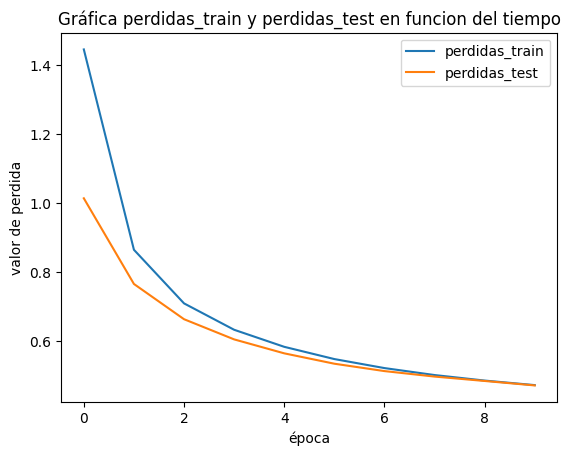

In [36]:
graficar_perdidas(perdidas_train,perdidas_en_test)

A su vez, no vemos evidencia de sobreajuste en esta ejecución, ya que las precisiones aumentan de una época a otra, decidimos entonces explorar que sucede cuando aumentamos el número de épocas a 20

In [37]:
precisiones_test20, perdidas_train20, m20, perdidas_en_test20 = evaluar_modelo(NeuralNetwork,[0.01],numero_epocas=20)

Evaluando el modelo para tasa de aprendizaje: 0.01
Epoca 1, Loss: 1.485, Accuracy: 72.76666666666667%
Epoca 2, Loss: 0.873, Accuracy: 75.76666666666667%
Epoca 3, Loss: 0.707, Accuracy: 78.1%
Epoca 4, Loss: 0.628, Accuracy: 79.91666666666667%
Epoca 5, Loss: 0.577, Accuracy: 81.51666666666667%
Epoca 6, Loss: 0.541, Accuracy: 82.28333333333333%
Epoca 7, Loss: 0.515, Accuracy: 82.91666666666667%
Epoca 8, Loss: 0.495, Accuracy: 83.75%
Epoca 9, Loss: 0.479, Accuracy: 83.65%
Epoca 10, Loss: 0.467, Accuracy: 84.48333333333333%
Epoca 11, Loss: 0.456, Accuracy: 84.91666666666667%
Epoca 12, Loss: 0.446, Accuracy: 84.98333333333333%
Epoca 13, Loss: 0.438, Accuracy: 85.2%
Epoca 14, Loss: 0.430, Accuracy: 85.33333333333333%
Epoca 15, Loss: 0.424, Accuracy: 85.48333333333333%


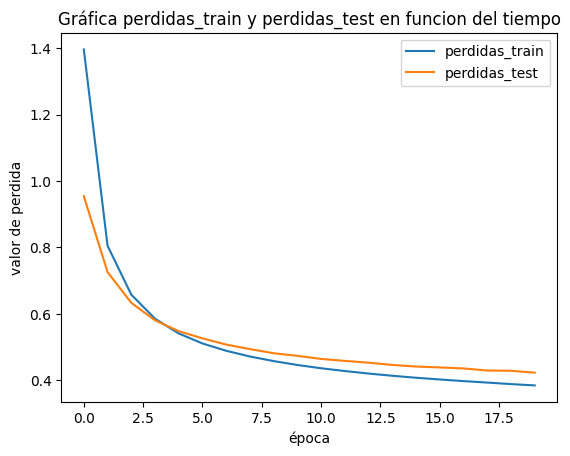

In [ ]:
graficar_perdidas(perdidas_train20,perdidas_en_test20)

Como podemos observar, no tenemos una evidencia significativa de sobreajuste ya que la precisión (accuracy) en el conjunto de prueba continúa mejorando a medida que aumenta el número de épocas. No se observa un estancamiento o un descenso en la precisión del conjunto de prueba, lo que sugiere que el modelo no ha memorizado los datos de entrenamiento y todavía puede generalizar bien a datos no vistos.

Observamos que la accuracy sobre el conjunto de testing aumenta ligeramente al entrenar durante más épocas, lo que confirma nuestra hipótesis anterior, no obstante, al aumentar más el número de épocas, se corre el riesgo de sobreajustar el modelo a los datos de entrenamiento. Esto se verifica en la gráfica, dado que la distancia entre ambas representaciones se va haciendo mayor conforme avanza el número de épocas.


### iv) Reporte gráficamente la evolución de la pérdida en el conjunto de entrenamiento y de la accuracy sobre el conjunto de validación en función de las iteraciones.


Dados los datos recolectados anteriormente, durante el entrenamiento y durante la validación, las representaciones gráficas respectivas son:

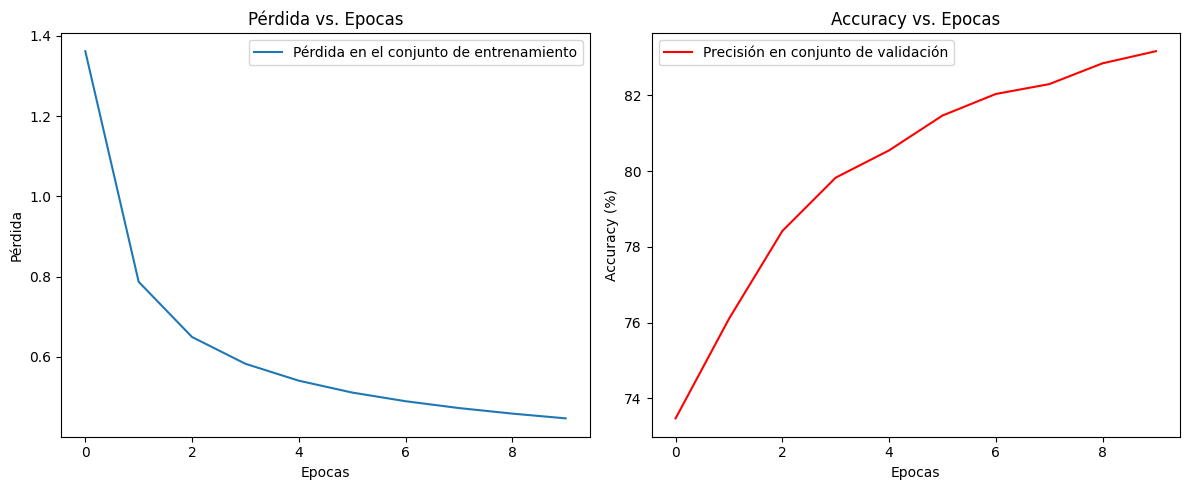

In [ ]:
plt.figure(figsize=(12, 5))                             # Graficamos pérdida en conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(perdidas_train, label='Pérdida en el conjunto de entrenamiento')
plt.title('Pérdida vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)                                    # Graficamos precisión en conjunto de validación
plt.plot(precisiones_test, label='Precisión en conjunto de validación', color='r')
plt.title('Accuracy vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

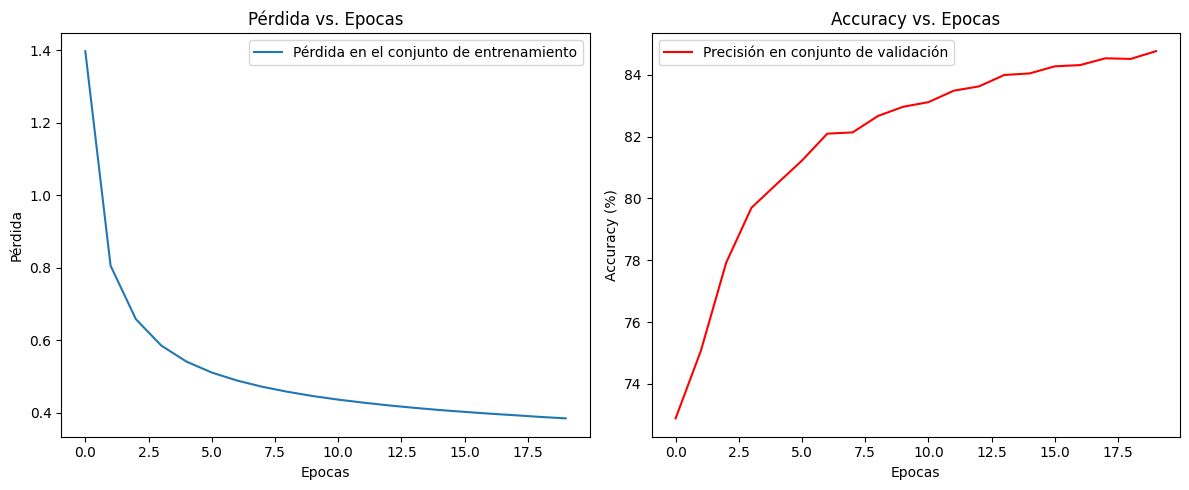

In [ ]:
plt.figure(figsize=(12, 5))                             # Graficamos pérdida en conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(perdidas_train20, label='Pérdida en el conjunto de entrenamiento')
plt.title('Pérdida vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)                                    # Graficamos precisión en conjunto de validación
plt.plot(precisiones_test20, label='Precisión en conjunto de validación', color='r')
plt.title('Accuracy vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Como ya fue mencionado, al no existir evidencia clara de sobreajuste, vemos que en el gráfico correspondiente a la evolución de la accuracy sobre el conjunto de validación, se presenta una función estrictamente creciente. Dicha observación corresponde a las 10 épocas indicadas en la consigna.


Después de entrenar el modelo durante 20 épocas, no se ha observado un sobreajuste claro en los datos. La gráfica correspondiente a la evolución de la pérdida en los conjuntos de validación y entrenamiento muestran una tendencia generalmente decreciente a lo largo de las 20 épocas, lo que indica que el modelo continúa mejorando su capacidad para generalizar a datos no vistos.

No obstante, se identifican dos sucesos:



*   El valor absoluto de la pendiente de ambos gráficos de la parte IV empieza a disminuir al aproximarnos a la décima época
*   El valor absoluto de la diferencia de las pérdidas de la sección anterior aumenta más conforme pasan las 10 épocas y se incrementa al explorar con 20 épocas.


Esto puede ser un indicio de que el modelo podría sobreajustarse en caso de que se lo continúe entrenando mediante más épocas, por lo que recomendamos que, para este modelo, que carece de un mecanismo de regularización, no se continúe el entrenamiento más allá de 20 épocas.

## Parte B Proponga tres arquitecturas adicionales que busquen mejorar los resultados, modificando la cantidad de unidades, la cantidad de capas ocultas, y/o diferentes funciones de activación. Para cada una, evalúe su rendimiento sobre un conjunto de validación, con diferentes valores de tasa de aprendizaje.

Para esta parte, evaluaremos el rendimiento de las arquitecturas propuestas a continuación, utilizando como valores de tasa de aprendizaje: 0.2, 0.1 y 0.01. Dichos valores surgen de un análisis preliminar donde consideramos valores superiores a 0.2 e inferiores a 0.01. Sin embargo los mejores resultados en general se corresponden a 0.1 como veremos a continuación. A su vez seguiremos entrenando durante 10 épocas ya que en la parte A no vimos sobreajuste con dicha cantidad. Sin embargo, para diferentes configuraciones, en la siguiente parte si tendremos sobreajuste ya que hay accuracies que disminuyen de una época a la siguiente.

In [ ]:
tasas = [0.2, 0.1, 0.01]

#### 1. Arquitectura con más unidades en la capa oculta y función de activación ReLU.

Para esta Arquitectura aumentaremos el número de unidades en la capa oculta de 32 a 128.

In [ ]:
class NeuralNetworkMasNeuronas(nn.Module):
    def __init__(self):
        super(NeuralNetworkMasNeuronas, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)                      # Más unidades
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()                                 # Utilizamos ReLU como función de activación

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Evaluamos el rendimiento del clasificador para las tasas de aprendizaje 0.2, 0.1 y 0.01:

In [ ]:
precisiones, perdidas_en_train, mNeuronas, perdidas_en_test  = evaluar_modelo(NeuralNetworkMasNeuronas, tasas)

Los datos que se obtuvieron son:

| Modelo           | Tasa 0.2 |       |       | Tasa 0.1 |       |       | Tasa 0.01 |       |       |
|------------------|----------|-------|-------|----------|-------|-------|-----------|-------|-------|
|                  | Epoca    | Pérdida (train) | Accuracy | Epoca | Pérdida (train) | Accuracy | Epoca | Pérdida (train) | Accuracy |
| Más neuronas     | 1        | 0.562  | 83.34%  | 1     | 0.513    | 84.03% | 1     | 0.673     | 81.51% |
| Más neuronas     | 2        | 0.420  | 83.94% | 2     | 0.388    | 82.15% | 2     | 0.468     | 82.79% |
| Más neuronas     | 3        | 0.382  | 83.43% | 3     | 0.353    | 85.64% | 3     | 0.429     | 83.75% |
| Más neuronas     | 4        | 0.359  | 85.91%  | 4     | 0.329    | 86.57% | 4     | 0.404     | 84.37%  |
| Más neuronas     | 5        | 0.341  | 86.84% | 5     | 0.310    | 86.72% | 5     | 0.386     | 84.72% |
| Más neuronas     | 6        | 0.326  | 85.21% | 6     | 0.295    | 87.18% | 6     | 0.371     | 85.31% |
| Más neuronas     | 7        | 0.315  | 85.48% | 7     | 0.282    | 87.12% | 7     | 0.359     | 85.19% |
| Más neuronas     | 8        | 0.302  | 85.59% | 8     | 0.271    | 86.54% | 8     | 0.348     | 86.27% |
| Más neuronas     | 9        | 0.296  | 86.65% | 9     | 0.259    | 85.87% | 9     | 0.338     | 86.19% |
| Más neuronas     | 10       | 0.286  | 85.44% | 10    | 0.254    | 85.21% | 10    | 0.330     | 85.82% |


Por lo tanto, los mejores resultados para dicha arquitectura se obtienen al considerar una tasa de aprendizaje de 0.01, alcanzando una accuracy de 85.82%, superior a la del modelo de la parte a.i). Sin embargo, cabe destacar que la mayor accuracy obtenida sobre el corpus de testing, se da para la tasa 0.1, concretamente sobre la sexta época. Esta tasa (87.18 %) es 3.69% superior a la obtenida en la parte a.i) para el caso de las 10 épocas

A su vez, cabe destacar que a diferencia de la parte a.i), vemos que el modelo sobreajusta al disminuir la accuracy, por ejemplo, al pasar a la octava época con tasa de aprendizaje 0.2. Graficamos la evolución de la pérdida para visualizar esto.

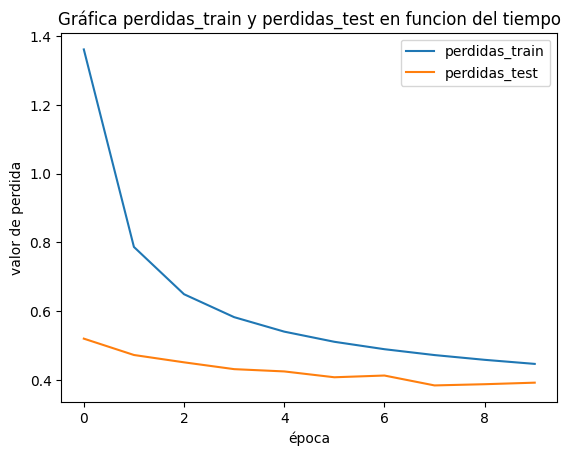

In [ ]:
graficar_perdidas(perdidas_train,perdidas_en_test)

Podemos ver como la pendiente de la evolución de las pérdidas en el conjunto test decrece hasta la quinta época. Luego, observamos una pequeña subida ahí es donde tenemos nuestro primer indicio de sobreajuste. Al incrementar el tamaño de la red le otorgamos mayor capacidad de representación y por ende es mas fácil que esta sobreajuste a los datos. Sin embargo, esta red logra una accuracy superior a la de la parte "a", lo cual entendemos que es porque la red más grande tiene la capacidad de aprender características más complejas y representaciones más sofisticadas de los datos. A pesar de la tendencia al sobreajuste, esta mayor capacidad de representación le permite capturar patrones más complejos en las imágenes de entrenamiento, lo que resulta en un rendimiento generalmente mejorado en términos de accuracy.

#### 2. Arquitectura con dos capas ocultas

Para esta arquitectura aumentaremos el número de capas ocultas, de 1 a 2.

In [ ]:
class NeuralNetworkMasOcultas(nn.Module):
    def __init__(self):
        super(NeuralNetworkMasOcultas, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)                          # Agregamos una capa oculta extra respecto a la red base de parte a).
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Evaluamos el rendimiento del clasificador para las tasas de aprendizaje 0.2, 0.1 y 0.01:

In [ ]:
prec, perd, mOcultas, perd_test = evaluar_modelo(NeuralNetworkMasOcultas, tasas)

Los datos que se obtienen son:

| Modelo      | Tasa 0.2 |       |       | Tasa 0.1 |       |       | Tasa 0.01 |       |       |
|-------------|----------|-------|-------|----------|-------|-------|-----------|-------|-------|
|             | Epoca    | Pérdida | Accuracy | Epoca | Pérdida  | Accuracy | Epoca | Pérdida   | Accuracy |
| Más ocultas | 1        | 0.562  | 83.36% | 1     | 0.543    | 82.39% | 1     | 0.798     | 80.41% |
| Más ocultas | 2        | 0.414  | 84.36% | 2     | 0.399    | 84.45% | 2     | 0.483     | 82.52% |
| Más ocultas | 3        | 0.374  | 84.22% | 3     | 0.359    | 85.01% | 3     | 0.437     | 83.36% |
| Más ocultas | 4        | 0.351  | 84.49% | 4     | 0.336    | 86.33% | 4     | 0.410     | 84.56% |
| Más ocultas | 5        | 0.336  | 86.29% | 5     | 0.317    | 87.23% | 5     | 0.389     | 85.12% |
| Más ocultas | 6        | 0.320  | 86.69% | 6     | 0.303    | 85.88% | 6     | 0.373     | 85.62% |
| Más ocultas | 7        | 0.310  | 86.8%  | 7     | 0.291    | 87.7%  | 7     | 0.360     | 85.76% |
| Más ocultas | 8        | 0.303  | 86.68% | 8     | 0.281    | 87.97% | 8     | 0.347     | 86.57% |
| Más ocultas | 9        | 0.296  | 86.84% | 9     | 0.273    | 87.96% | 9     | 0.338     | 86.57% |
| Más ocultas | 10       | 0.287  | 87.31% | 10    | 0.264    | 86.73% | 10    | 0.328     | 86.77% |


Por lo tanto, los mejores resultados para dicha arquitectura se obtienen al considerar una tasa de aprendizaje de 0.2, alcanzando una accuracy de 87.31%, prácticamente un 3.82% superior a la del modelo de la parte a.i).

In [ ]:
prec, perd, mOcultas, perd_test = evaluar_modelo(NeuralNetworkMasOcultas, [0.1])

Evaluando el modelo para tasa de aprendizaje: 0.1
Epoca 1, Loss: 0.549, Accuracy: 82.84%
Epoca 2, Loss: 0.401, Accuracy: 84.56%
Epoca 3, Loss: 0.361, Accuracy: 85.79%
Epoca 4, Loss: 0.336, Accuracy: 86.57%
Epoca 5, Loss: 0.320, Accuracy: 87.19%
Epoca 6, Loss: 0.303, Accuracy: 86.96%
Epoca 7, Loss: 0.293, Accuracy: 87.24%
Epoca 8, Loss: 0.282, Accuracy: 86.76%
Epoca 9, Loss: 0.271, Accuracy: 87.89%
Epoca 10, Loss: 0.264, Accuracy: 87.26%


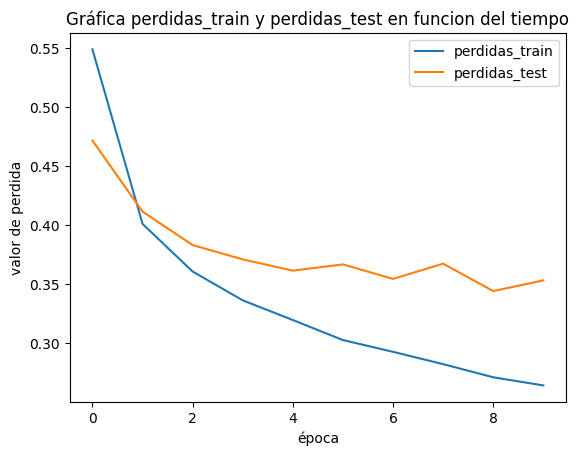

In [ ]:
graficar_perdidas(perd,perd_test)

Podemos observar como se da el sobreajuste a partir de la época 4, dado que la pérdida en el conjunto de entrenamiento no tiene una pendiente que sea siempre decreciente, lo cual indica que a partir de la época 10 no obtendremos resultados significativamente mejores en términos de accuracy sobre el conjunto de testeo.

#### 3.Arquitectura con más Neuronas y más capas ocultas

Para esta arquitectura utilizamos dos capas ocultas que contienen 512 neuronas cada una. Se sigue utilizando ReLU como función de activación ya que dio mejores resultados respecto a las funciones $sigmoid()$ y $tanh()$

In [ ]:
class NeuralNetworkMasNeuronasYCapas(nn.Module):
    def __init__(self):
        super(NeuralNetworkMasNeuronasYCapas, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Evaluamos el rendimiento del clasificador para las tasas de aprendizaje 0.2, 0.1 y 0.01:

In [ ]:
prec, perd, mOpt, perd_test = evaluar_modelo(NeuralNetworkMasNeuronasYCapas, tasas)

Los datos que se obtienen son:

| Modelo              | Tasa 0.2 |       |       | Tasa 0.1 |       |       | Tasa 0.01 |       |       |
|---------------------|----------|-------|-------|----------|-------|-------|-----------|-------|-------|
|                     | Epoca    | Pérdida | Accuracy | Epoca | Pérdida  | Accuracy | Epoca | Pérdida   | Accuracy |
| Más neuronas y capas| 1        | 0.542  | 82.28% | 1     | 0.520    | 83.45% | 1     | 0.740     | 80.92% |
| Más neuronas y capas| 2        | 0.387  | 84.94% | 2     | 0.376    | 86.36% | 2     | 0.465     | 82.34% |
| Más neuronas y capas| 3        | 0.343  | 86.87% | 3     | 0.332    | 87.51% | 3     | 0.418     | 84.91% |
| Más neuronas y capas| 4        | 0.314  | 87.29% | 4     | 0.306    | 86.14% | 4     | 0.389     | 85.08% |
| Más neuronas y capas| 5        | 0.291  | 86.89% | 5     | 0.283    | 87.85% | 5     | 0.367     | 85.84% |
| Más neuronas y capas| 6        | 0.275  | 87.76% | 6     | 0.266    | 88.03% | 6     | 0.351     | 85.89% |
| Más neuronas y capas| 7        | 0.261  | 87.76% | 7     | 0.250    | 87.69% | 7     | 0.335     | 86.41% |
| Más neuronas y capas| 8        | 0.244  | 87.69% | 8     | 0.237    | 88.51% | 8     | 0.323     | 86.75% |
| Más neuronas y capas| 9        | 0.234  | 88.53% | 9     | 0.224    | 88.31% | 9     | 0.311     | 87.21% |
| Más neuronas y capas| 10       | 0.224  | 88.27% | 10    | 0.211    | 88.53% | 10    | 0.300     | 86.81% |


Por lo tanto, los mejores resultados para dicha arquitectura se obtienen al considerar una tasa de aprendizaje de 0.1, alcanzando una accuracy de 88.53%, prácticamente un 5.4% superior a la del modelo de la parte a.i).

Dado que la mayor puntuación se obtuvo con la tasa 0.1, realizamos una evaluación más con esa misma tasa para graficar la evolución de la pérdida de nuestro modelo en el conjunto de testing

In [ ]:
prec, perd, mOpt, perd_test = evaluar_modelo(NeuralNetworkMasNeuronasYCapas, [0.1])

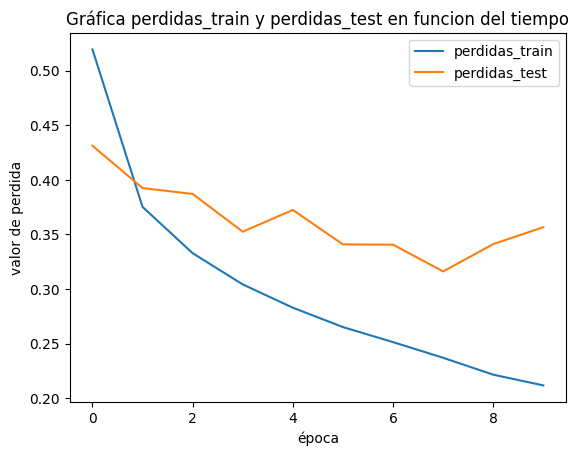

In [ ]:
graficar_perdidas(perd,perd_test)

In [ ]:
def graficar_accuracy(accuracy):

  # Crear gráfica
  plt.plot(accuracy, label='accuracy')

  # Agregar título y etiquetas
  plt.title('Gráfica de accuracy en funcion del tiempo')
  plt.xlabel('época')
  plt.ylabel('accuracy')

  # Mostrar leyenda
  plt.legend()

  # Mostrar gráfica
  plt.show()

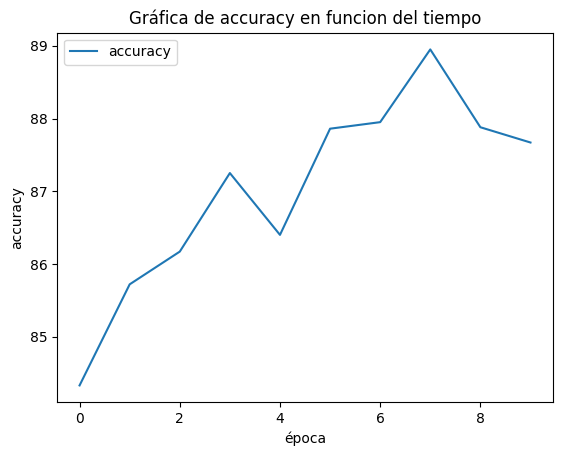

In [ ]:
graficar_accuracy(prec)

Observamos un pico en la accuracy del modelo sobre la época 7.

#### 4. Resumen de las arquitecturas propuestas

Como pudimos observar las mejores accuracies que obtuvieron los modelos según las arquitecturas propuestas y las correspondientes tasas de aprendizaje que mejor se ajustaban a las mismas son:

| Modelo              | Tasa   | Pérdida | Accuracy |
|---------------------|---------|---------|-----------|
| Más neuronas | 0.01     | 0.251  | 85.82%    |
| Más ocultas | 0.2     | 0.287   | 87.31%    |
| Más neuronas y capas | 0.1     | 0.211   | 88.53%    |

Por lo tanto en la Parte C utilizaremos el modelo "NeuronalNetworkMasNeuronasYCapas" con una tasa de aprendizaje igual a 0.1.

## Parte C

### A partir del mejor modelo obtenido en b), sugiera y aplique algún mecanismo de regularización y vuelva a evaluar sobre el conjunto de validación, igual que en el paso anterior.


El modelo: "NeuralNetworkMasNeuronasYCapas", obtuvo el mejor rendimiento: una accuracy de 88.53% al terminar la décima época, para la tasa de aprendizaje 0.1. En esta sección, aplicaremos tres técnicas de regularización a dicho modelo:

- **Dropout:** es una técnica de regularización en la que, durante el entrenamiento, algunas neuronas (o unidades) se apagan o se "descartan" con una cierta probabilidad. Esto previene que las neuronas se vuelvan demasiado dependientes entre sí durante el entrenamiento, lo que puede llevar a un sobreajuste. Exploraremos varias probabilidades de dropout con el fin de obtener un mejor control del sobreajuste.
- **Regularización L2:** agrega un término a la función de pérdida del modelo que penaliza los valores grandes en los pesos de la red neuronal. Esto ayuda a controlar el crecimiento excesivo de los pesos y, en última instancia, a mejorar la generalización del modelo.
$$Loss = Error(Y - \widehat{Y}) +  \lambda \sum_1^n w_i^{2}$$
Exploraremos distintos valores de weight decay ($\lambda$) para este método.
- **Batch Normalization**: consiste en normalizar las activaciones de las neuronas en una capa en cada mini-batch. Es decir, hacer que las activaciones tengan una media cero y una varianza unitaria. De esta forma, tenemos que en cada neurona:

  - Calcula la media y la varianza del mini-batch para esa neurona.
  - Normaliza las activaciones de las neuronas usando la media y la varianza calculadas.
  - Escala y desplaza las activaciones normalizadas utilizando dos parámetros (gamma y beta), que son aprendidos durante el entrenamiento. Esto permite que el modelo conserve la representación original si eso es lo que resulta ser óptimo.


#### Análisis Dropout

Declaramos nuestro modelo, aplicando la técnica de Dropout al mencionado "NeuralNetworkMasNeuronasYCapas". Evaluamos diferentes posibles valores de dropout con la tasa de aprendizaje 0.1, ya que en general, fue la que otorgó mejores resultados.

Los valores que consideraremos: 0.05, 0.1, 0.15, 0.2, 0.25 y 0.3 se eligen debido a un análisis preliminar, donde a través de distintas ejecuciones vimos que con valores menores a 0.05 y mayores a 0.3, el rendimiento comenzaba a caer respecto a los que si consideramos.

In [ ]:
import torch.nn as nn
class NeuralNetworkRegularizado(nn.Module):
   def __init__(self, dropout):
       super(NeuralNetworkRegularizado, self).__init__()
       self.fc1 = nn.Linear(28*28, 512)
       self.fc2 = nn.Linear(512, 512)
       self.fc4 = nn.Linear(512, 10)
       self.relu = nn.ReLU()
       self.dropout = nn.Dropout(dropout)
   def forward(self, x):
       x = x.view(-1, 28*28)
       x = self.relu(self.fc1(x))
       x = self.dropout(x)
       x = self.relu(self.fc2(x))
       x = self.dropout(x)
       x = self.fc4(x)
       return x

Ahora veamos las accuracies que se obtienen al considerar los valores mencionados de probabilidad de dropout, al evaluar el modelo entrenado durante 10 épocas.

In [ ]:
dropouts = [0.05,0.1,0.15,0.2,0.25,0.3]
for dropout in dropouts:
  prec, perd, mOpt, perd_test = evaluar_modelo(NeuralNetworkRegularizado,[0.1],dropout,l2=False)

Evaluando el modelo para tasa de aprendizaje 0.1 para el valor de dropout 0.05
Epoca 1, Loss: 0.525, Accuracy: 84.62%
Epoca 2, Loss: 0.383, Accuracy: 85.03%
Epoca 3, Loss: 0.341, Accuracy: 86.49%
Epoca 4, Loss: 0.315, Accuracy: 86.87%
Epoca 5, Loss: 0.294, Accuracy: 87.62%
Epoca 6, Loss: 0.278, Accuracy: 87.59%
Epoca 7, Loss: 0.264, Accuracy: 87.2%
Epoca 8, Loss: 0.248, Accuracy: 87.31%
Epoca 9, Loss: 0.239, Accuracy: 87.15%
Epoca 10, Loss: 0.226, Accuracy: 88.39%
Evaluando el modelo para tasa de aprendizaje 0.1 para el valor de dropout 0.1
Epoca 1, Loss: 0.530, Accuracy: 83.54%
Epoca 2, Loss: 0.388, Accuracy: 85.31%
Epoca 3, Loss: 0.350, Accuracy: 86.64%
Epoca 4, Loss: 0.322, Accuracy: 86.5%
Epoca 5, Loss: 0.303, Accuracy: 87.01%
Epoca 6, Loss: 0.288, Accuracy: 87.14%
Epoca 7, Loss: 0.274, Accuracy: 86.77%
Epoca 8, Loss: 0.260, Accuracy: 87.54%
Epoca 9, Loss: 0.249, Accuracy: 88.46%
Epoca 10, Loss: 0.239, Accuracy: 87.83%
Evaluando el modelo para tasa de aprendizaje 0.1 para el valor 

| Dropout | Pérdida | Accuracy |
|---------|--------------------------|-------------------------------|
| 0.05    | 0.226                    | 88.39%                        |
| 0.1     | 0.239                    | 87.83%                        |
| 0.15    | 0.252                    | 88.44%                        |
| 0.2     | 0.263                    | 88.18%                        |
| 0.25    | 0.280                    | 87.86%                        |
| 0.3     | 0.293                    | 86.89%                        |


Concluimos que el mejor valor de dropout para una tasa de 0.1 es 0.15, ya que se obtiene la mayor accuracy (88.44%). Sin embargo esta forma de regularización no mejora los resultados de la parte anterior, donde se obtuvo una mayor accuracy. Ahora, si analizamos el rendimiento para dicha probabilidad de 0.15 de Dropout, vemos como en la siguiente tabla, solamente dos épocas reportan sobreajuste debido a la obtención de un accuracy menor respecto a la época anterior. Por lo tanto, se reduce en uno el número de épocas que presentan sobreajuste respecto al modelo sin regularización. No obstante como ya mencionamos, la accuracy obtenida en la décima época luego de evaluar sobre el conjunto de validación es menor.

| Época | Pérdida        | Accuracy             |
|-------|----------------|----------------------|
| 1     | 0.543          | 83.36%               |
| 2     | 0.399          | 85.46%               |
| 3     | 0.358          | 86.04%               |
| 4     | 0.332          | 86.77%               |
| 5     | 0.313          | 86.49%               |
| 6     | 0.296          | 87.05%               |
| 7     | 0.284          | 87.0%                |
| 8     | 0.271          | 87.74%               |
| 9     | 0.262          | 88.16%               |
| 10    | 0.252          | 88.44%               |


In [ ]:
prec, perd, mOpt, perd_test = evaluar_modelo(NeuralNetworkRegularizado,[0.1],dropout,l2=False)

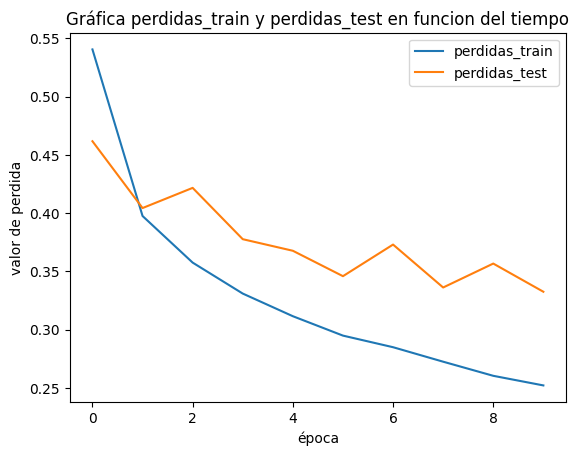

In [ ]:
graficar_perdidas(perd,perd_test)

Si comparamos esta gráfica con la anterior, nos damos cuenta de que en esta, inclinación de la gráfica de pérdidas en el conjunto de teste "apunta" hacia abajo más que la de la sección anterior, cuya arquitectura de red sólo difiere en el método de regularización aplicado (ninguno vs Dropout), por lo que entendemos que aquí se eliminó una parte del sobreajuste, dejando a la red aprender a reconocer diferentes patrones o características de las imágenes que difieren en la accuracy sobre el conjunto de testing y provocan esos "picos" que vemos en la gráfica

#### Análisis regularización L2

Declaramos el modelo, igual al mejor de la sección B pero con el agregado correspondiente para aplicar la regularización.

In [ ]:
class NeuralNetworkConRegularizacionL2(nn.Module):
    def __init__(self, weight_decay=1e-3):
        super(NeuralNetworkConRegularizacionL2, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.weight_decay = weight_decay

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
  # implementación de la regularizacion l2
    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param, p=2)
        return self.weight_decay * l2_reg

Definimos cuatro valores de λ a analizar y los evaluamos utilizando 0.1 de tasa. Dichos valores candidatos: $1 \times 10^{-5}, 1 \times 10^{-4}, 1 \times 10^{-3}$ y $1 \times 10^{-2}$, son elegidos para poder visualizar cómo influye esta ponderación en la pérdida. Realizamos pruebas preliminares al igual que en las partes anteriores y consideramos estos valores.
- Para las pruebas con valores muy pequeños de λ, el modelo tiende a sobreajustar los datos de entrenamiento muy rápidamente, y por lo tanto, sucede lo siguiente:
> - La pérdida es la mínima por sobre todos los λ.
> - Se observa evidencia de sobreajuste a partir de épocas tempranas, ya que los valores de *accuracy* sobre el conjunto de validación empiezan a decaer rápidamente.
- Para las pruebas con valores muy grandes de λ, mostramos el impacto de una ponderación excesiva en la regularización $L_2$. En esta parte, el término de regularización domina sobre el término de ajuste, lo que lleva a una pérdida significativa en la capacidad del modelo para ajustarse tanto a los datos de entrenamiento como a los datos no vistos. Corroboramos esto en la parte de más abajo, al ver que la pérdida aún luego de la época número 10, no ha descendido de 0.5. Incluímos $1 \times 10^{-2}$, un ejemplo de valor en el que ocurre un subajuste significativo.

Mostraremos entonces los valores intermedios, que proporcionan un término de regularización moderado que ayudan a contrarrestar el sobreajuste y a mejorar la capacidad del modelo de ajustarse correctamente a los datos.

In [ ]:
weigth_decay_values=[1e-5, 1e-4, 1e-3, 1e-2]
for weight_decay in weigth_decay_values:
  precisiones, perdidas, mOpt, perdidas_test = evaluar_modelo(NeuralNetworkConRegularizacionL2,[0.1],l2=True,weight_decay=weight_decay)

Evaluando el modelo para tasa de aprendizaje 0.1 y weight decay 1e-05
Epoca 1, Loss: 0.520, Accuracy: 85.03%
Epoca 2, Loss: 0.373, Accuracy: 83.85%
Epoca 3, Loss: 0.333, Accuracy: 85.69%
Epoca 4, Loss: 0.304, Accuracy: 87.23%
Epoca 5, Loss: 0.284, Accuracy: 87.25%
Epoca 6, Loss: 0.266, Accuracy: 87.55%
Epoca 7, Loss: 0.251, Accuracy: 88.1%
Epoca 8, Loss: 0.238, Accuracy: 87.74%
Epoca 9, Loss: 0.224, Accuracy: 88.88%
Epoca 10, Loss: 0.213, Accuracy: 88.51%
Evaluando el modelo para tasa de aprendizaje 0.1 y weight decay 0.0001
Epoca 1, Loss: 0.521, Accuracy: 83.75%
Epoca 2, Loss: 0.379, Accuracy: 86.01%
Epoca 3, Loss: 0.337, Accuracy: 85.94%
Epoca 4, Loss: 0.310, Accuracy: 87.58%
Epoca 5, Loss: 0.291, Accuracy: 88.31%
Epoca 6, Loss: 0.273, Accuracy: 88.43%
Epoca 7, Loss: 0.258, Accuracy: 88.02%
Epoca 8, Loss: 0.245, Accuracy: 88.11%
Epoca 9, Loss: 0.231, Accuracy: 88.64%
Epoca 10, Loss: 0.218, Accuracy: 88.17%
Evaluando el modelo para tasa de aprendizaje 0.1 y weight decay 0.001
Epoca 1,

| Weight Decay | Pérdida (Loss) Época 10 | Precisión (Accuracy) Época 10 |
|--------------|-------------------------|-------------------------------|
| 1e-05        | 0.213                   | 88.51%                        |
| 1e-04       | 0.218                   | 88.17%                        |
| 1e-03       | 0.263                   | 88.11%                        |
| 1e-02        | 0.515                   | 86.68%                        |


Como podemos ver en la tabla anterior, el valor $λ = 1 \times 10^{-5}$ ofrece el mejor rendimiento al considerar el valor de *accuracy* obtenido al evaluar posteriormente a la décima época. Sin embargo, el modelo original de la parte B obtenía una accuracy de 88.53%, en menores tiempos de ejecución.

Analizamos la evolución de la funcion de pérdida en el conjunto de testing y el conjunto de entrenamiento:

##### $λ = 1 \times 10^{-5}$

In [ ]:
precisiones, perdidas, mOpt, perdidas_test = evaluar_modelo(NeuralNetworkConRegularizacionL2,[0.1],l2=True,weight_decay=1e-5)

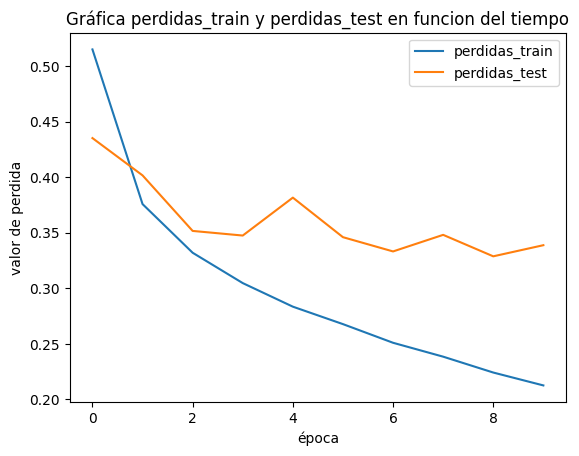

In [ ]:
graficar_perdidas(perdidas,perdidas_test)

##### $λ = 1 \times 10^{-3}$

In [ ]:
precisiones, perdidas, mOpt, perdidas_test = evaluar_modelo(NeuralNetworkConRegularizacionL2,[0.1],l2=True,weight_decay=1e-3)

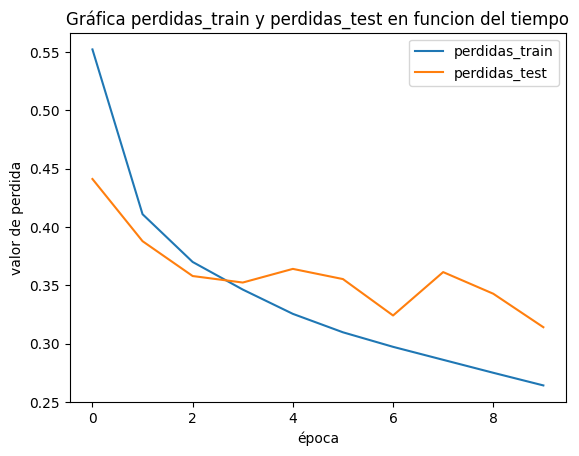

In [ ]:
graficar_perdidas(perdidas,perdidas_test)

##### $λ = 1 \times 10^{-2}$

In [ ]:
precisiones, perdidas, mOpt, perdidas_test = evaluar_modelo(NeuralNetworkConRegularizacionL2,[0.1],l2=True,weight_decay=1e-2)

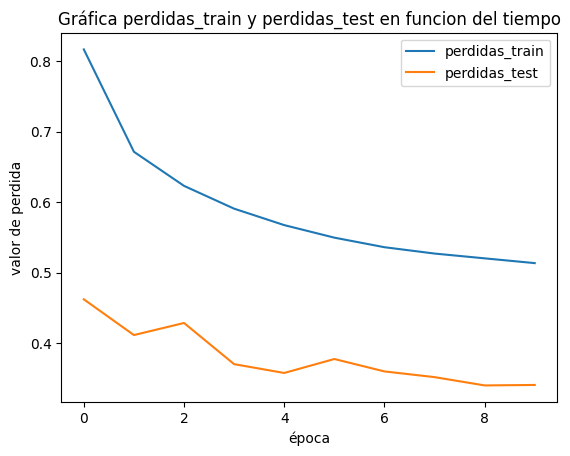

In [ ]:
graficar_perdidas(perdidas,perdidas_test)

Podemos ver como el lambda de la regularización L2 tiene impactos significativos a la hora de entrenar el modelo.

- **Lambda pequeño (1e-5):** Un valor pequeño de lambda implica una regularización más suave, lo que permite que el modelo se ajuste más a los datos de entrenamiento. Por lo tanto, como en las etapas anteriores, obtenemos el mismo sobreajuste y la pendiente de la gráfica que representa la pérdida en el conjunto de testeo es "positiva" a menos de las oscilaciones que presenta y a partir de cierto punto. El aumento de la pérdida en el conjunto de pruebas indica dificultades en la generalización. Observamos que además este lambda es el que contó con mejores resultados previamente.

- **Lambda mediano (1e-3):** Conseguimos una regularización relativamente equilibrada, manteniendo la capacidad de ajuste del modelo y permitiendo un buen equilibrio entre la pérdida en el conjunto de entrenamiento (ajuste a los datos, en azul), y la generalización del modelo (pérdida en testing, en naranja).

- **Lambda grande (1e-2):** Implica una regularización más fuerte, esto restringe la complejidad del modelo y por lo tanto su capacidad de aprender. Si esta es demasiado fuerte, se tienen dificultades para ajustarse a los datos de entrenamiento y vemos como la pérdida en el mismo (azul) se mantiene bastante alta luego de las diez épocas. Esto es un indicador de subajuste y no es lo que deseamos en nuestro modelo, ya que como vimos previamente, aunque haya sobreajuste al tratarse de un corpus con poco ruido, las redes previas funcionan relativamente bien.

#### Análisis Batch - Normalization

Declaramos el modelo, igual al mejor de la sección B pero con el agregado correspondiente para aplicar la regularización.

In [ ]:
import torch.nn as nn

class NeuralNetworkWithBatchNormalization(nn.Module):
    def __init__(self):
        super(NeuralNetworkWithBatchNormalization, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

Veamos el rendimiento del Modelo "NeuralNetworkMasNeuronasYCapas" al aplicarle esta técnica, considerando las tasas de aprendizaje 0.2, 0.1 y 0.01:

In [ ]:
accBatch, perdBatch, mBatch, perdBarch_test = evaluar_modelo(NeuralNetworkWithBatchNormalization, tasas)

Evaluando el modelo para tasa de aprendizaje: 0.2
Epoca 1, Loss: 0.515, Accuracy: 83.33%
Epoca 2, Loss: 0.364, Accuracy: 86.56%
Epoca 3, Loss: 0.322, Accuracy: 87.12%
Epoca 4, Loss: 0.292, Accuracy: 87.2%
Epoca 5, Loss: 0.269, Accuracy: 88.7%
Epoca 6, Loss: 0.250, Accuracy: 87.73%
Epoca 7, Loss: 0.236, Accuracy: 88.05%
Epoca 8, Loss: 0.223, Accuracy: 88.1%
Epoca 9, Loss: 0.208, Accuracy: 88.62%
Epoca 10, Loss: 0.195, Accuracy: 88.38%
Evaluando el modelo para tasa de aprendizaje: 0.1
Epoca 1, Loss: 0.478, Accuracy: 85.15%
Epoca 2, Loss: 0.355, Accuracy: 85.17%
Epoca 3, Loss: 0.312, Accuracy: 86.88%
Epoca 4, Loss: 0.287, Accuracy: 87.11%
Epoca 5, Loss: 0.263, Accuracy: 88.24%
Epoca 6, Loss: 0.245, Accuracy: 88.34%
Epoca 7, Loss: 0.228, Accuracy: 88.48%
Epoca 8, Loss: 0.211, Accuracy: 88.79%
Epoca 9, Loss: 0.199, Accuracy: 88.56%
Epoca 10, Loss: 0.187, Accuracy: 88.66%
Evaluando el modelo para tasa de aprendizaje: 0.01
Epoca 1, Loss: 0.484, Accuracy: 85.15%
Epoca 2, Loss: 0.351, Accuracy:

| Tasa de Aprendizaje | Pérdida | Accuracy |
|---------------------|-------------------------|-------------------------------|
| 0.2                 | 0.195                   | 88.38%                        |
| 0.1                 | 0.187                   | 88.66%                        |
| 0.01                | 0.187                   | 88.32%                        |


Como se puede observar, para tasa de aprendizaje 0.1, se obtiene una *accuracy* de 88.66%, la cual supera al 88.53% del modelo sin regularización. Por lo tanto, consideraremos este modelo para la parte D. Es decir, el mejor modelo obtenido es: "NeuralNetworkWithBatchNormalization". A su vez destacamos que con el mismo sólo se detecta sobreajuste al llegar a la novena época, considerando tasa de aprendizaje 0.1. Por lo tanto, se reduce la cantidad de veces que se detecta sobreajuste respecto al modelo original y las otras técnicas de regularización.

## Parte D

###  Con el mejor modelo obtenido luego de los pasos anteriores, evalúe su performance sobre el conjunto de evaluación utilizando accuracy, precisión, recall y medida F1 para cada una de las clases. Construya la matriz de confusión. Comente los resultados y compare con los reportados en el sitio del dataset.

Utilizamos la biblioteca sklearn.metrics para el cálculo de las métricas solicitadas. Como mencionamos anteriormente, utilizaremos el modelo: "NeuralNetworkWithBatchNormalization" con tasa de aprendizaje 0.1, ya que continúa siendo el que nos brinda mejores resultados, para la métrica accuracy: 88.66%.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#### NeuralNetworkWithBatchNormalization

In [ ]:
mBatch.eval()       # Configuramos al modelo en modo de evaluación, donde mOpt es el modelo correspondiente a NeuralNetworkMasNeuronasYCapas
                  # el cual obtuvo los mejores resultados dadas las pruebas realizadas hasta el momento.

todas_las_predicciones = []
etiquetas_verdaderas = []

with torch.no_grad():
    for data, target in test_loader:
        outputs = mBatch(data)
        _, predicted = torch.max(outputs.data, 1)
        todas_las_predicciones.extend(predicted.cpu().numpy())
        etiquetas_verdaderas.extend(target.cpu().numpy())

In [ ]:
accuracy = accuracy_score(etiquetas_verdaderas, todas_las_predicciones)
precision = precision_score(etiquetas_verdaderas, todas_las_predicciones, average=None)
recall = recall_score(etiquetas_verdaderas, todas_las_predicciones, average=None)
f1 = f1_score(etiquetas_verdaderas, todas_las_predicciones, average=None)
conf_matrix = confusion_matrix(etiquetas_verdaderas, todas_las_predicciones)
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print("Accuracy:", accuracy)
print("Accuracy por clase:", class_accuracies)
print("Precision por clase:", precision)
print("Recall por clase:", recall)
print("F1 por clase:", f1)
print("Matriz de confusión:\n", conf_matrix)

Accuracy: 0.8913
Accuracy por clase: [0.758 0.98  0.816 0.918 0.839 0.938 0.766 0.966 0.976 0.956]
Precision por clase: [0.87528868 0.9929078  0.83180428 0.88953488 0.81853659 0.9904963
 0.69133574 0.91563981 0.97893681 0.95409182]
Recall por clase: [0.758 0.98  0.816 0.918 0.839 0.938 0.766 0.966 0.976 0.956]
F1 por clase: [0.81243301 0.98641168 0.82382635 0.90354331 0.82864198 0.96353364
 0.72675522 0.94014599 0.9774662  0.95504496]
Matriz de confusión:
 [[758   0  19  30   3   0 183   1   6   0]
 [  3 980   0  12   2   0   2   0   1   0]
 [ 13   1 816   8  99   0  63   0   0   0]
 [ 16   5  12 918  22   0  24   0   3   0]
 [  1   0  55  40 839   0  65   0   0   0]
 [  0   0   0   1   0 938   0  45   1  15]
 [ 69   1  76  20  58   0 766   0  10   0]
 [  0   0   0   0   0   3   0 966   0  31]
 [  6   0   3   3   2   2   4   4 976   0]
 [  0   0   0   0   0   4   1  39   0 956]]


Dados los datos obtenidos, vemos que el rendimiento en términos de accuracy del clasificador evaluado anteriormente, es superior respecto al rendimiento de humanos no expertos en el área moda. Esto es debido a que en una evaluación colectiva del desempeño humano, junto a otras consideraciones, la precisión obtenida fue de 83.5%. Sin embargo, también es ampliamente inferior al 96.7% obtenido con el clasificador WRN40 basado en 8.9 millones de parámetros. Dicha clasificación contó con un preprocesamiento estándar previo y aumentos, como recortes aleatorios, volteos horizontales, etc.

Como podemos ver tanto en los conjuntos de métricas por clase como en la matriz de confusión, la clase con label 6 (se inicia desde label 0): Shirt, es la que le resulta más compleja al clasificador en términos de los resultados obtenidos, donde se obtuvo una F1  de 0.73 aproximadamente, notoriamente inferior a las F1 del resto de las clases que superaron todas el 0.80. Esto se debe principalmente a que el recall correspondiente es de 0.766, y la precisión de 0.691.

 La clase que mejor se califica corresponde a la clase 1, asociada a "pantalones", debido a la F1 de 0.986. No obstante, las clases 5, 8 y 9 también tienen un rendimiento similar, y por lo tanto muy bueno.

## Parte E

### Muestre las diez instancias del conjunto de evaluación más “difíciles” para el clasificador construido, utilizando como medida la entropía. Comente los resultados

#### Modelo MasNeuronasYCapas con regularización Batch-Normalization

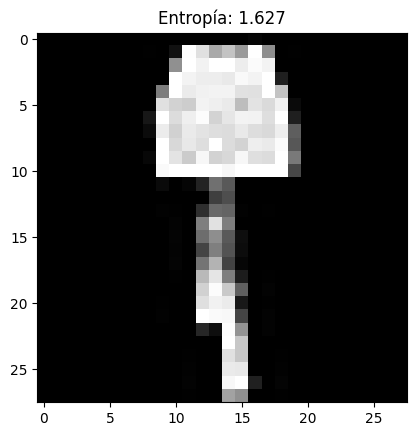

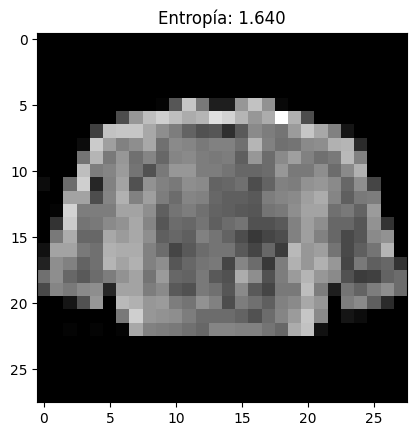

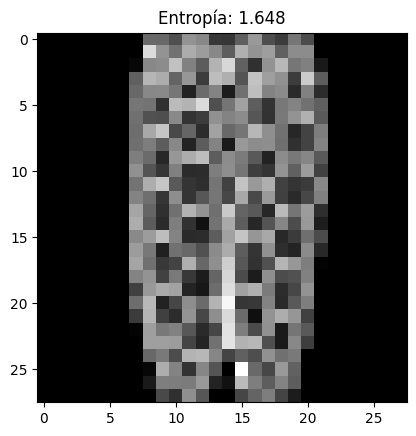

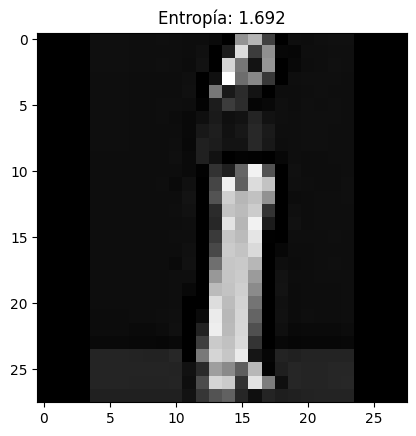

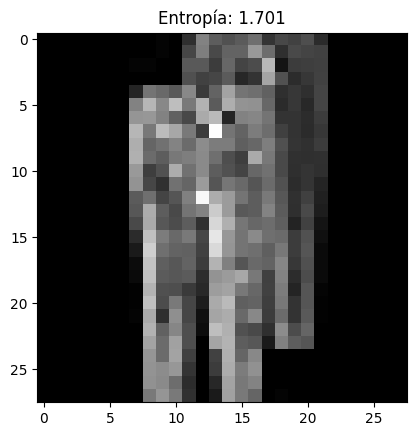

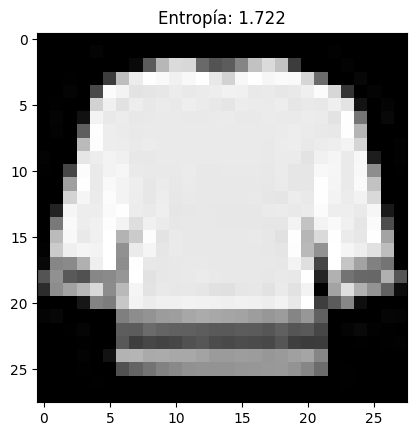

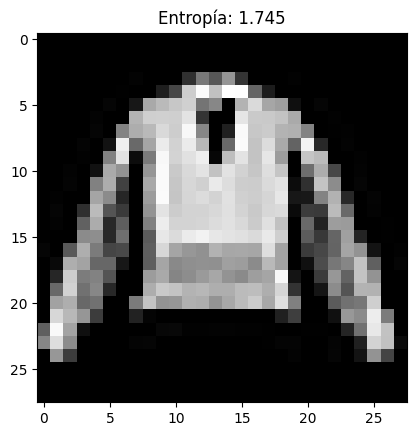

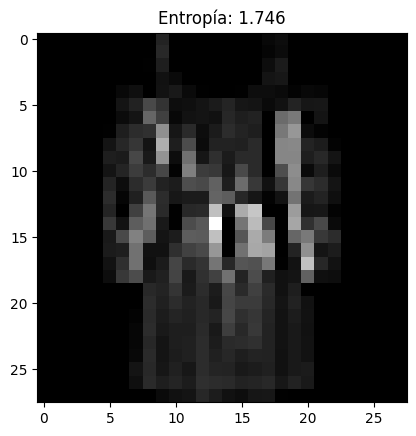

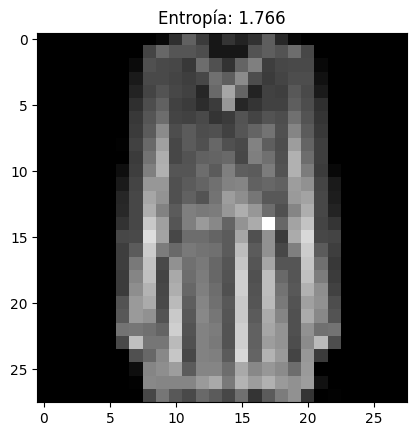

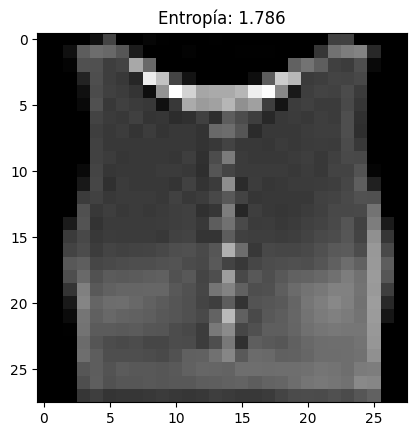

In [ ]:
import torch.nn.functional as F

mBatch.eval()

entropias = []

with torch.no_grad():
    for data, _ in test_loader:
        outputs = mBatch(data)
        # Calculamos las probabilidades usando softmax
        probabilities = F.softmax(outputs, dim=1)

        # Calculamos la entropía para cada muestra en el lote
        entropy = (-probabilities * torch.log(probabilities + 1e-9)).sum(dim=1)
        entropias.extend(entropy.cpu().numpy())

# Ordenamos las entropias y tomamos los índices de las 10 mayores
top_10_indices = np.argsort(entropias)[-10:]

# Mostramos estas imágenes
import matplotlib.pyplot as plt

for index in top_10_indices:
    plt.imshow(test_dataset[index][0].squeeze().numpy(), cmap='gray')
    plt.title(f"Entropía: {entropias[index]:.3f}")
    plt.show()

Luego de observar las imágenes, al equipo le resulta entendible la dificultad que se le presenta al clasificador, clasificar dichas instancias. Pues salvo para las imágenes 2, 6, 7 y 10, el equipo discrepó en la clasificación del resto. Esto demuestra en forma subjetiva, la dificultad que representa la clasificación de ciertas instancias, ya que a veces ni siquiera de forma visual, resulta sencilla la clasificación, lo cual se reflejó también en la parte anterior donde la evaluación de humanos alcanzó una accuracy de solo 0.835.

## 4. Conclusiones

- Observamos que el rendimiento en general de la red "NeuralNetworkWithBatchNormalization" es bueno para no tratarse de una arquitectura muy compleja.
 Sin embargo, como pudimos ver en el sitio web asociado al dataset, otras arquitecturas de red más complejas ofrecen resultados mucho mejores.

- A su vez, por más que el rendimiento de la primera red resultó muy por debajo respecto a los rendimientos de las redes creadas posteriormente, nos sorprende que haya igualado prácticamente al rendimiento humano. Esto especialmente al tratarse de una red muy básica, demostrando de cierta forma el poder de las redes neuronales en cuanto a tareas de clasificación, representando el estado del arte de dicho campo.
- Las 3 técnicas de regularización aplicadas al mejor modelo obtenido luego de la parte B fueron:
  - Dropout
  - Regularización L2
  - Batch Normalization

- De los experimentos, se desprende que la tercer técnica retornó el mejor rendimiento debido a una mayor *accuracy*. A su vez para la tasa de aprendizaje 0.1 que arrojaba los mejores resultados en general para los distintos modelos, se detectó sobreajuste solamente al llegar a la novena época. Mientras que, en el modelo original fueron 3 ocasiones, y para las mejores configuraciones de parámetros relativas a las técnicas Dropout y Regularización L2, fue de 2. Por lo tanto, concluimos que el mejor método en este caso, para esta red neuronal se trata de la regularización por Batch Normalization.

- Basándonos en los resultados de la parte C para "Regularización L2", consideramos que un buen aspecto a mejorar sería aumentar aún más las capas o el número de neuronas de la red y experimentar nuevamente con distintos valores de λ, esto se deduce porque es complicado inferir objetivamente si es mejor o no el realizar Regularización L2 con valores pequeños de λ, ya que el accuracy solo decrece al momento de aumentarlo, lo cual significa que el modelo trabaja mejor cuanta menos regularización se tiene. Esto podría ser un indicador de que la red neuronal no está sobreajustando significativamente los datos y se puede intentar retener más información sobre las propiedades de las imágenes.

- En la parte B, se observa una importante variación en cuanto a la evolución de las pérdidas y accuracy de los modelos, para poder analizar lógicamente esto es necesario tener en cuenta que estamos trabajando sobre un corpus que no posee inherentemente ruido sobre sus elementos, además, nuestra red neuronal aprenderá a reconocer diferentes patrones, con distinto nivel de complejidad que se podrán alinear más o menos con la consigna de la tarea. Consideramos que estas fluctuaciones no sólo pueden ser resultado de un posible sobreajuste a los datos de entrenamiento, sino que también al tipo de patrón que la red es capaz de aprender dada su arquitectura y los mecanismos que se utilizan para entrenarla.